In [1]:
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 1. Metadata Preprocessing
metadata_path = 'train.csv'
metadata_df = pd.read_csv(metadata_path)

# Function to clean and normalize poster filenames
def clean_filename(title):
    # Remove unwanted special characters except for - and '.
    title = re.sub(r'[^\w\s\-\'\.\!\&\(\)]', '', title)
    return title

# Generate normalized filenames by combining the title and year
metadata_df['Poster_Filename'] = metadata_df['Title'].apply(clean_filename) + '_' + metadata_df['Year'].astype(str) + '.jpg'


In [3]:
metadata_df.head()

,Title,Year,Director,Runtime(min),Country,BoxOffice,Actor1,Actor2,Actor3,Genre1,Genre2,Genre3,Budget,Poster_Filename
0,Star Wars: Episode VII - The Force Awakens,2015,J.J. Abrams,138,United States,1.010325e+09,Daisy Ridley,John Boyega,Oscar Isaac,Action,Adventure,Sci-Fi,4.821539e+08,Star Wars Episode VII - The Force Awakens_2015...
1,Jurassic World,2015,Colin Trevorrow,124,United States,7.047932e+08,Chris Pratt,Bryce Dallas Howard,Ty Simpkins,Action,Adventure,Sci-Fi,2.319085e+08,Jurassic World_2015.jpg
2,Furious 7,2015,James Wan,137,United States,3.807690e+08,Vin Diesel,Paul Walker,Dwayne Johnson,Action,Thriller,Action,2.696610e+08,Furious 7_2015.jpg
3,Avengers: Age of Ultron,2015,Joss Whedon,141,United States,4.951040e+08,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Action,Adventure,Sci-Fi,3.937051e+08,Avengers Age of Ultron_2015.jpg
4,Minions,2015,Kyle Balda,91,United States,3.624738e+08,Sandra Bullock,Jon Hamm,Michael Keaton,Animation,Adventure,Comedy,7.981967e+07,Minions_2015.jpg


In [4]:
# 2. Poster Preprocessing
poster_folder = 'posters_train'
image_size = (224, 224)  # Resize all images to 224x224

# Process and normalize poster images
X_images = []
for filename in metadata_df['Poster_Filename']:
    img_path = os.path.join(poster_folder, filename) # Construct image path
    if os.path.exists(img_path):
        img = Image.open(img_path).convert('RGB') # Open and convert image to RGB
        img = img.resize(image_size)
        img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
        X_images.append(img)
    else:
        print(filename)
        # Replace missing images with random noise
        X_images.append(np.random.normal(0.5, 0.1, (*image_size, 3)))

X_images = np.array(X_images)  # Convert list to NumPy array

Star Wars Episode VII - The Force Awakens_2015.jpg
Jurassic World_2015.jpg
Furious 7_2015.jpg
Avengers Age of Ultron_2015.jpg
Minions_2015.jpg
Spectre_2015.jpg
Inside Out_2015.jpg
Mission Impossible - Rogue Nation_2015.jpg
The Hunger Games Mockingjay - Part 2_2015.jpg
The Martian_2015.jpg
Fifty Shades of Grey_2015.jpg
Cinderella_2015.jpg
The Revenant_2015.jpg
Ant-Man_2015.jpg
Hotel Transylvania 2_2015.jpg
San Andreas_2015.jpg
Terminator Genisys_2015.jpg
Monster Hunt_2015.jpg
Home_2015.jpg
Mad Max Fury Road_2015.jpg
The Good Dinosaur_2015.jpg
The SpongeBob Movie Sponge Out of Water_2015.jpg
Maze Runner The Scorch Trials_2015.jpg
The Divergent Series Insurgent_2015.jpg
Pitch Perfect 2_2015.jpg
Mojin The Lost Legend_2015.jpg
Lost in Hong Kong_2015.jpg
The Peanuts Movie_2015.jpg
Pixels_2015.jpg
Daddy's Home_2015.jpg
Spy_2015.jpg
Alvin and the Chipmunks The Road Chip_2015.jpg
Goodbye Mr. Loser_2015.jpg
Ted 2_2015.jpg
Tomorrowland_2015.jpg
Everest_2015.jpg
Straight Outta Compton_2015.jpg
The

In [5]:
# 3. Metadata Feature Preprocessing
# Normalize numerical features
numerical_features = ['Runtime(min)', 'Budget']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_numeric = scaler.fit_transform(metadata_df[numerical_features].values)

# Encode categorical features
categorical_features = ['Director', 'Country', 'Genre1', 'Genre2', 'Genre3', 'Actor1', 'Actor2', 'Actor3']
encoders = {}  # Dictionary to store encoders for each categorical feature
X_categorical = []
for feature in categorical_features:
    le = LabelEncoder()  # Initialize label encoder
    metadata_df[feature] = le.fit_transform(metadata_df[feature])  # Transform categorical data to numerical
    X_categorical.append(metadata_df[feature].values)   # Store transformed feature
    encoders[feature] = le

# Combine all categorical features into a single array
X_categorical = np.column_stack(X_categorical)

# Target variable (log-transformed BoxOffice values)
Y = np.log1p(metadata_df['BoxOffice'].values)

In [6]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_img_train, X_img_val, X_num_train, X_num_val, X_cat_train, X_cat_val, Y_train, Y_val = train_test_split(
    X_images, X_numeric, X_categorical, Y, test_size=0.2, random_state=42)


In [7]:

# 4. Model Definition
# Define ResNet50-based image feature extractor

image_input = layers.Input(shape=(224, 224, 3)) # Input layer for images
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Pre-trained ResNet50
base_model.trainable = False  # Freeze the base model
x = base_model(image_input, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
# Define MLP for metadata features
metadata_input = layers.Input(shape=(X_numeric.shape[1] + X_categorical.shape[1],))  # Input layer for metadata
y = layers.Dense(128, activation='relu')(metadata_input)  # Dense layer with ReLU activation
y = layers.Dropout(0.3)(y)
y = layers.Dense(64, activation='relu')(y)
y = layers.Dropout(0.3)(y)

In [9]:
# Combine image and metadata branches
combined = layers.concatenate([x, y])  # Concatenate features from both branches
output = layers.Dense(1)(combined)   # Output layer (regression)

In [10]:
# Compile model with different optimizers

# Adam optimizer
model = models.Model(inputs=[image_input, metadata_input], outputs=output)
optimizer = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

In [ ]:
# Adamw optimizer
optimizer_adamw = optimizers.AdamW(learning_rate=0.0005)
model = models.Model(inputs=[image_input, metadata_input], outputs=output)
model.compile(optimizer=optimizer_adamw, loss='mean_squared_error', metrics=['mae'])

In [ ]:
#  RMSprop optimizer
optimizer_rmsprop = optimizers.RMSprop(learning_rate=0.0005)
model = models.Model(inputs=[image_input, metadata_input], outputs=output)
model.compile(optimizer=optimizer_rmsprop, loss='mean_squared_error', metrics=['mae'])

In [11]:
# Train the model
# Early stopping callback to prevent overfitting
callback = callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit([X_img_train, np.hstack([X_num_train, X_cat_train])], Y_train,
                    validation_data=([X_img_val, np.hstack([X_num_val, X_cat_val])], Y_val),
                    epochs=100, batch_size=16, callbacks=[callback])



Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 32s 225ms/step - loss: 241.9628 - mae: 12.1806 - val_loss: 25.3314 - val_mae: 4.1113
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 63.8292 - mae: 6.3048 - val_loss: 24.5044 - val_mae: 4.2282
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 37.7145 - mae: 4.9249 - val_loss: 25.6818 - val_mae: 4.5270
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 25.5724 - mae: 4.0627 - val_loss: 21.3749 - val_mae: 4.1685
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 21.0350 - mae: 3.6616 - val_loss: 16.9395 - val_mae: 3.6995
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 15.7025 - mae: 3.2002 - val_loss: 11.1698 - val_mae: 2.9387
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 12.2120 - mae: 2.8154 - val_loss: 13.2616 - val_mae: 3.3208
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 12.2534 - mae: 2.8117 - val_loss: 8.7036 - val_mae: 2.6116
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━

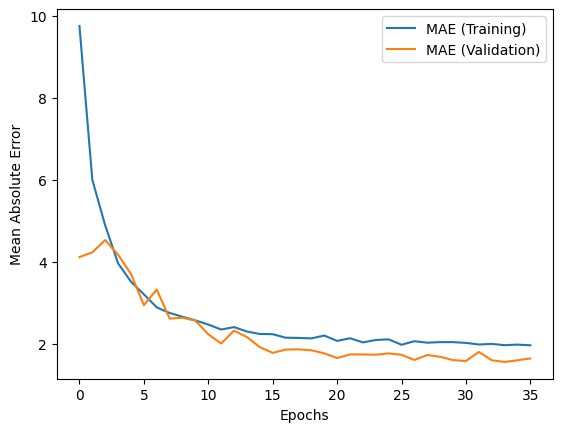

Model eğitimi ve analizi tamamlandı.


In [12]:
# 5. Performance Analysis
plt.figure()
plt.plot(history.history['mae'], label='MAE (Training)')
plt.plot(history.history['val_mae'], label='MAE (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [13]:
# Load test metadata

test_metadata_path = 'test.csv'
test_metadata_df = pd.read_csv(test_metadata_path)

# Function to clean and normalize poster filenames

def clean_filename(title):
    # Remove unwanted special characters
    title = re.sub(r'[^\w\s\-\'\.\!\&\(\)]', '', title)
    return title


# Generate normalized poster filenames for the test set
test_metadata_df['Poster_Filename'] = test_metadata_df['Title'].apply(clean_filename) + '_' + test_metadata_df['Year'].astype(str) + '.jpg'

In [14]:
# Process test poster images
poster_folder2 = 'posters_test'
image_size = (224, 224)
X_test_images = []
for filename in test_metadata_df['Poster_Filename']:
    img_path = os.path.join(poster_folder2, filename) # Construct image path
    if os.path.exists(img_path):
        # If the image exists, process it
        img = Image.open(img_path).convert('RGB') # Open and convert to RGB
        img = img.resize(image_size)
        img = np.array(img) / 255.0  # Normalize [0,1]
        X_test_images.append(img)
    else:
        # If the image is missing, replace it with random noise
        print(filename) # Print missing filenames for debugging
        X_test_images.append(np.random.normal(0.5, 0.1, (*image_size, 3)))  # Gürültülü resim

X_test_images = np.array(X_test_images) # Convert list to NumPy array

Avatar_2009.jpg
Harry Potter and the Half-Blood Prince_2009.jpg
Ice Age Dawn of the Dinosaurs_2009.jpg
Transformers Revenge of the Fallen_2009.jpg
2012_2009.jpg
Up_2009.jpg
The Twilight Saga New Moon_2009.jpg
Sherlock Holmes_2009.jpg
Angels & Demons_2009.jpg
The Hangover_2009.jpg
Alvin and the Chipmunks The Squeakquel_2009.jpg
Night at the Museum Battle of the Smithsonian_2009.jpg
Star Trek_2009.jpg
Monsters vs. Aliens_2009.jpg
X-Men Origins Wolverine_2009.jpg
Terminator Salvation_2009.jpg
Fast & Furious_2009.jpg
A Christmas Carol_2009.jpg
Inglourious Basterds_2009.jpg
The Proposal_2009.jpg
The Blind Side_2009.jpg
G.I. Joe The Rise of Cobra_2009.jpg
G-Force_2009.jpg
This Is It_2009.jpg
The Princess and the Frog_2009.jpg
Cloudy with a Chance of Meatballs_2009.jpg
It's Complicated_2009.jpg
Public Enemies_2009.jpg
District 9_2009.jpg
The Ugly Truth_2009.jpg
The Final Destination_2009.jpg
Watchmen_2009.jpg
Paul Blart Mall Cop_2009.jpg
He's Just Not That Into You_2009.jpg
Couples Retreat_20

In [15]:
# Process numerical metadata for the test set
X_test_numeric = scaler.transform(test_metadata_df[numerical_features].values)

In [16]:
# Process categorical metadata for the test set
X_test_categorical = []
for feature in categorical_features:
    # Use the encoder from training to transform test data
    encoder = encoders[feature]
    test_labels = test_metadata_df[feature]

    # Handle unseen labels by assigning them to an "Unknown" category
    test_labels = test_labels.apply(lambda x: x if x in encoder.classes_ else 'Unknown')

    if 'Unknown' not in encoder.classes_:
        encoder.classes_ = np.append(encoder.classes_, 'Unknown')

    # Transform the test labels using the encoder
    X_test_categorical.append(encoder.transform(test_labels))
X_test_categorical = np.column_stack(X_test_categorical)


In [17]:
# Extract actual BoxOffice values from the test set and apply log transformation
Y_test_actual = np.log1p(test_metadata_df['BoxOffice'].values)

In [18]:
# Make predictions using the trained model
Y_test_pred = model.predict([X_test_images, np.hstack([X_test_numeric, X_test_categorical])])

# Evaluate the model's performance

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(Y_test_actual, Y_test_pred) # Calculate Mean Squared Error
mae = mean_absolute_error(Y_test_actual, Y_test_pred) # Calculate Mean Absolute Error

print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set MAE: {mae:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Test Set MSE: 3.9721
Test Set MAE: 1.6208


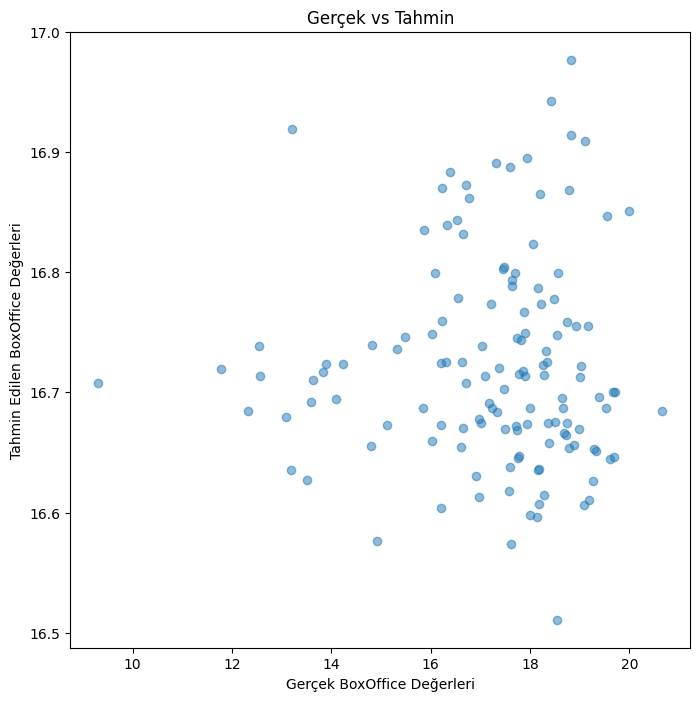

In [19]:
# Plotting actual vs predicted BoxOffice values
plt.figure(figsize=(8, 8))
plt.scatter(Y_test_actual, Y_test_pred, alpha=0.5)
plt.xlabel('Gerçek BoxOffice Değerleri')
plt.ylabel('Tahmin Edilen BoxOffice Değerleri')
plt.title('Gerçek vs Tahmin')
plt.show()
